In [3]:
########################### Libraries ####################################
import astropy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter
import scipy
from scipy.signal import argrelextrema
from astroML.time_series import lomb_scargle
from gatspy.periodic import LombScargleFast

In [4]:
#ОКПЗ
data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')
data = data.to_pandas()
datalistt=data['Max'].tolist()
datalist=data['Min I'].tolist()

In [5]:
data.head()

,NNo,GCVS,J2000.0,Type,Max,Min I,Min II,Epoch,Year,Period,M-m,Spectrum,References,Other desig. p.m.(as/yr) Epoch Ident. New type GCVS
0,010001,R And *,002401.95 +383437.3,M,5.8,15.2,NaN,V |53820.,NaN,409.2,38,"S3,5e-S8,8e(M7e)",HIP 00002,|-0.016 -0.035|2000.0 | |Hip |M ...
1,010002,S And *,004243.1 +411605.0,SNI,5.8,< 16.,NaN,V |09775.,1885,NaN,NaN,(SNI),V 377 V 338,=M31 V0894| |1885.67 | |Lit. ...
2,010003,T And,002223.15 +265945.8,M,7.7,14.5,NaN,V |50854.,NaN,281.0,46,M4e-M7.5e,00001 00002,|-0.007 -0.003|2000.0 | |Tyc2 |M ...
3,010004,U And,011529.70 +404308.4,M,9.0,15.0,NaN,V |49564.,NaN,347.7,40,M6e,00001 00002,|+0.009 -0.011|2000.0 | |UCAC2 |M ...
4,010005,V And,005006.28 +353910.1,M,9.0,15.2,NaN,V |51528.,NaN,256.4,45,M2e-M3e,00001 00002,|-0.007 -0.007|2000.0 | |NPM |M ...


### GCVS input ('Max'  and 'Min I' columns) corrections

In [6]:
name=datalistt[39]# save strange nan?
for i in range(len(datalist)):
    try:
        if datalist[i][0]=='<':
            datalist[i]=datalist[i][2:]
        if datalist[i][-1]==':':
            datalist[i]=datalist[i][:4]
        if datalist[i][0]=='(':
            datalist[i]=100
    except:
        print(i)
        
for i in range(len(datalistt)):
    try:
        if datalistt[i]==datalistt[39]:
            datalistt[i]=0
        if datalistt[i][0]=='|':
            datalistt[i]=datalistt[1][1:]
    except:
        print(i)        

17
39
40
77
147
153
261
812
835
931
953
1209
1495
1567
1588
1946
2120
2149
2155
2163
2316
2395
2528
2821
2856
3287
3431
3952
4113
4155
5118
5144
5287
5299
5330
5340
5464
5465
5553
5745
5809
5810
6129
6130
6157
6178
6185
6210
6304
6616
6617
6812
7207
7236
7243
7526
7531
7545
7548
7604
7754
7755
7942
7959
7967
8029
8404
8445
8555
8558
8647
8888
8895
8909
8964
9610
9880
9907
10020
10063
10115
10140
10145
10477
10478
10531
10824
10866
10869
10929
10934
10937
10938
10939
11343
11472
11570
11636
11646
11672
11858
11890
11903
12316
12320
12358
12440
12486
12512
12530
12659
12700
12872
13353
13437
13622
13866
14079
14189
14191
14243
14259
14336
14344
14532
14902
14907
15015
15150
15796
15814
15833
15844
15886
15887
15896
15897
16066
16130
16131
16132
16138
16148
16186
16358
16463
16877
17070
17303
17365
17590
17988
17992
19067
19155
19159
19160
19753
19798
19831
19873
20179
20197
20200
20213
20216
20349
20417
20875
20878
20885
20902
20903
20908
21113
21162
21200
21230
21303
21497
22120
22431
2

 # GCVS analyses  

### Here we remove stars which min mag< 12m

In [7]:
data['index']=data.index
i=0
k=0
index=[]
for i in range(len(datalist)):
    try:
        if float(datalist[i])<=10:
            index.append(i)
    except:
        print(1)
data=data.drop(index,axis=0)     
data=data.reset_index()        
data.shape

1
1


(48549, 16)

### Here we calculate the num of stars which max-min range does not fully belong to [12:20]

In [8]:
# k=0
# d=0
# for i in range(len(datalist)):
#     try:
#         if float(datalistt[i])<12:
#             d=d+1
# #             data=data.drop(index=i,axis=1)
#     except:
#         k=k+1
# print(d)
#18980

### result N of stars which belong to [12:20]

In [9]:
# data.shape[0]-d
#35999

In [10]:
# drop them
# data1=data1.drop(index=d,axis=1,inplace=True)
# data1=data1.reset_index()
# data1

### Take only necessary columns + coordinates preparation

In [11]:
# ОКПЗ
# data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [12]:
data = data[['J2000.0', 'Type']]

In [13]:
# data = data.to_pandas()

In [14]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [15]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [16]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [17]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [18]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [19]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [20]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [21]:
data.reset_index(drop=True, inplace=True)

In [22]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [23]:
#sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

## Features engineering (for ML)

In [52]:
#Построение периодограммы (фурье спектра сигнала) для текущего значения obj_mag,obj_magerr,ang_freqs
# from astroML.time_series import lomb_scargle
# periods = np.linspace(0.01, 200, 500)
# ang_freqs = 2 * np.pi / periods
# power = lomb_scargle(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr), ang_freqs)
# # plot the results
# fig, ax = plt.subplots()
# ax.plot(periods, power)
# ax.set(ylim=(0, 0.8), xlabel='period (days)',
#        ylabel='Lomb-Scargle Power');

In [53]:
# peak_data = scipy.signal.find_peaks(power,prominence=0.05)
# f1=np.max(power[peak_data[0]])
# ind1=power[peak_data[0]].argmax()
# power[peak_data[0][ind1]]=0
# f2=np.max(power[peak_data[0]])
# ind2=power[peak_data[0]].argmax()
# print(periods[peak_data[0][ind1]])
# print(periods[peak_data[0][ind2]])
# print(periods[ind1])
# print(periods[ind2])

In [54]:
# model = LombScargleFast().fit(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr))
# period, power = model.periodogram_auto(nyquist_factor=200)
# print("period range: ({0}, {1})".format(period.min(), period.max()))
# print("number of periods: {0}".format(len(period)))
# print(type(periods))

In [24]:
data1=data# Для быстрой загрузки с сервера

In [25]:
# data1=data[42000:]

In [26]:
data1.iterrows()

<generator object DataFrame.iterrows at 0x000001D30C0C1DE0>

In [362]:
rows = np.random.choice(data.index.values, 3000)
print(data1.shape)
data1.head()

AttributeError: 'builtin_function_or_method' object has no attribute 'values'

## Sending requests with different conditions and parameters + saving files

In [519]:
# %%time
# obj_mjd1={}
# obj_mag1={}
# periods = np.linspace(0.01, 200, 500)
# ang_freqs = 2 * np.pi / periods
# my_data = pd.DataFrame({'obj_id':[],
#                         'filter':[],
# #                         'mean_magn':[],
# #                         'amplitude':[],
# #                         'trand_angle':[],
# #                         'skew' : [],
# #                         'std' : [],
# #                         'max_PSD' : [],
# #                         'max_fs' : [],
#                         'pointsN': [],
#                         'idN': [],
#                         'dist':[],
# #                         'dist1':[],
# #                         'dist2':[],                        
#                         'class':[]})
# i=0
# for item in data1.iterrows():
# #     obj_mjd1[i]=obj_mjd
# #     obj_mag1[i]=obj_mag
# #     i=i+1
# #     a=item[1].ra*u.degree
# #     b=item[1].dec*u.degree
#     try:
#         resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
#                                                                                                                           dec=item[1].dec, 
#         res = resp.json()
#         i=i+1
#         if len(res.keys())==2:
                                                                                                                          
#             if i%1000==0:
#                 print(i)
#             c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
#             c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
# #             c3=SkyCoord(res[list(res.keys())[2]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[2]]['meta']['coord']['dec']*u.degree)
# #             c4=SkyCoord(res[list(res.keys())[3]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[3]]['meta']['coord']['dec']*u.degree)
        
#             # sep = c1.separation(c2)
# #             sep1 = c3.separation(c1)
# #             sep2 = c3.separation(c2) 
# #             print(c1)
# #             print(res.keys())
# #             print(res[list(res.keys())[0]]['meta']['filter'])
# #             print(res[list(res.keys())[0]]['meta']['nobs'])
 
# # c3=SkyCoord(a,b)
#             for obj_id in res.keys():
#                 with open(obj_id+'.txt', 'w') as file:
#                     file.write(json.dumps(res))
                    
#     #             if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=5):
#                 obj_mjd = []
#                 obj_mag = []
#                 obj_magerr = []
#                 object_return = {}
#                 obj_filter = res[obj_id]['meta']['filter']
# #                     for ii in res[obj_id]['lc']:
# #                         obj_mjd.append(ii['mjd'])
# #                         obj_mag.append(ii['mag'])
# #                         obj_magerr.append(ii['magerr'])
#     #                 Fs = 1/((np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size)
#     #                 Fs = np.linspace(0.01, 10)
# #                     model = LombScargleFast().fit(obj_mjd, obj_mag, obj_magerr)
#     #                 period, power = model.periodogram_auto(nyquist_factor=200)
# #                     period=0
# #                     power=0
#                 object_return['obj_id'] = obj_id
#                 object_return['filter'] = res[obj_id]['meta']['filter']
# #                     object_return['mean_magn'] = np.array(obj_mag).mean()
# #                     object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
# #                     object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0] 
# #                     object_return['skew'] = scipy.stats.skew(np.array(obj_mag))
#                 object_return['pointsN'] = len(res[obj_id]['lc'])
#                 object_return['idN'] = len(res.keys())
# #                 object_return['dist'] = sep 
# #                 object_return['dist1'] = sep1
# #                 object_return['dist2'] = sep2

#     #                 D1=np.max(power[peak_data[0]])
#     #                 ind1=power[peak_data[0]].argmax()
#     #                 power[peak_data[0][ind1]]=0
#     #                 D2=np.max(power[peak_data[0]])
#     #                 ind2=power[peak_data[0]].argmax() 
# #                     object_return['max_fs'] =0
# #                     object_return['max_fs'] = 2*np.pi/(period[power.argmax()])
#     #                 object_return['max_fs1'] = 2*np.pi/(period[peak_data[0][ind2]])                
# #                     object_return['max_PSD'] = np.max(power)
#     #                 object_return['max_PSD1'] = D2
# #                     object_return['std'] = np.array(obj_mag).std()
#                 my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
#                                                           'filter' : [ object_return['filter'] ],
# #                                                           'mean_magn' :[ object_return['mean_magn'] ],
# #                                                           'amplitude' : [ object_return['amplitude'] ], 
# #                                                           'trand_angle' : [ object_return['trand_angle'] ],
# #                                                           'skew' : [ object_return['skew'] ],
# #                                                           'std' : [ object_return['std'] ],
# #                                                           'max_PSD' : [ object_return['max_PSD']],
# #                                                           'max_fs' : [ object_return['max_fs'] ],
#                                                           'pointsN' : [ object_return['pointsN']],
#                                                           'idN' : [ object_return['idN']],
#                                                           'dist' : [ object_return['dist']],
# #                                                           'dist1' : [ object_return['dist1']], 
# #                                                           'dist2' : [ object_return['dist2']],                                                           
#                                                           'class' : [ item[1].Type ] }),
#                                              ignore_index = True)
    
#     except Exception as ex:
#         print("file {} has error".format(item[0]), ex)
#     if item[0] % 1000 == 0 :
#         my_data.to_csv('backup_' + str(item[0]) + '.csv')    

### Viewing all the names in folder

In [62]:
from os import walk
f = []
mypath=r'C:\Users\rtut6\Desktop\Backup\1' # first (1) or second (2) folder
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [63]:
f

['1.txt',
 '10024.txt',
 '10097.txt',
 '10100.txt',
 '10102.txt',
 '10112.txt',
 '10135.txt',
 '10136.txt',
 '10139.txt',
 '10140.txt',
 '10146.txt',
 '10157.txt',
 '10212.txt',
 '10213.txt',
 '10217.txt',
 '10220.txt',
 '10240.txt',
 '1047.txt',
 '1048.txt',
 '1049.txt',
 '1052.txt',
 '1053.txt',
 '1055.txt',
 '1056.txt',
 '1058.txt',
 '1059.txt',
 '1062.txt',
 '1067.txt',
 '1070.txt',
 '1071.txt',
 '1079.txt',
 '109.txt',
 '1101.txt',
 '11029.txt',
 '11030.txt',
 '11035.txt',
 '11044.txt',
 '11065.txt',
 '11070.txt',
 '11073.txt',
 '11085.txt',
 '11088.txt',
 '11095.txt',
 '11100.txt',
 '11110.txt',
 '11116.txt',
 '11117.txt',
 '11119.txt',
 '11128.txt',
 '11129.txt',
 '1113.txt',
 '11136.txt',
 '11138.txt',
 '11158.txt',
 '11161.txt',
 '11168.txt',
 '11169.txt',
 '11170.txt',
 '11171.txt',
 '11175.txt',
 '11177.txt',
 '11187.txt',
 '11191.txt',
 '11193.txt',
 '1121.txt',
 '1126.txt',
 '113.txt',
 '1130.txt',
 '11309.txt',
 '11310.txt',
 '11317.txt',
 '11323.txt',
 '11324.txt',
 '113

In [64]:
for i in range(len(f)):
    try:
        f[i]=f[i][:-4]
    except:
        print('1')

In [99]:
# for i in range(len(f)):
#     if len(f[i])<13:
#         f.pop(i) 

### Fill names1 with files of first folder (1 id ) and names 2 with files of second folder (2 id) etc.

In [520]:
# names1=f
# names2=f
# names3=f

### id-distribution (numbers come from number of elements in folders

In [542]:
# my_data.head(20)
# my_data['idN'].value_counts().nlargest(n=5)  # пять самых больших классов
labels = '2.0 ID', '4.0 ID', '1.0 ID', '3.0 ID','6.0 ID'
sizes = [12580, 1610, 5330, 273,49] # Размеры пяти самых больших классов

import plotly.express as px
# df = px.data.gapminder().query("year == 2007").query("continent == 'Europe'")
# df.loc[df[''] < 2.e6, 'country'] = 'Other countries' # Represent only large countries
fig = px.pie(sizes, values=sizes, names=labels, title='ID distribution')
fig.show()

### Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec

Text(0.5, 1.0, 'Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec')

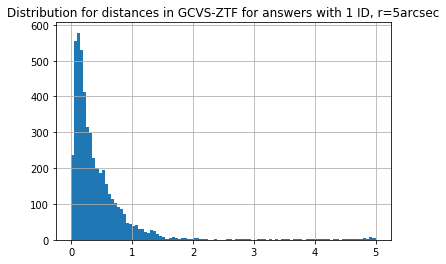

In [522]:
df = pd.read_csv(r'1IDobj.csv',sep='\t')
df['dist1']=df['dist1']
df['dist1'].hist(bins=100)
plt.title ("Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec") #данные по всему каталогу 

In [544]:
listl=[]
for item in names2: 
    with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
        res = file.read().replace("'", '"')
    res=json.loads(res)
    c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
    c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
    sep0 = c1.separation(c2)
    listl.append(sep0.value)

In [548]:
for i in range(len(listl)):
    listl[i]=listl[i]*3600

### Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec

Text(0.5, 1.0, 'Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec')

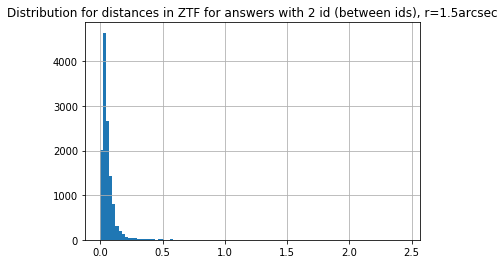

In [549]:
df=pd.DataFrame(index=range(len(listl)),columns=['degr'])
df['degr']=listl
df.hist(bins=100)
# np.cumsum(a)
plt.title ("Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec") #данные по всему каталогу 

### Create a DataFrame:

In [327]:
df=pd.DataFrame(columns=['ra','dec','Nobs','filter','Name'],index=range(35000))

### Each new row - one single observation (for each 2-id object we get 2 rows)

In [333]:
# i=0
for item in names2: # names1 or names2 (replace to switch)
    with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file: # 2 or 1 folder (replace to switch)
        res = file.read().replace("'", '"')
    res=json.loads(res)
#     c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
#     c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
#     sep0 = c1.separation(c2)
#     listl.append(sep0.value)
    if res[list(res.keys())[0]]['meta']['filter']=='zg':
        df['ra'][i]=round(res[list(res.keys())[0]]['meta']['coord']['ra'],3)
        df['dec'][i]=res[list(res.keys())[0]]['meta']['coord']['dec']
        df['Nobs'][i]=res[list(res.keys())[0]]['meta']['nobs']
        df['filter'][i]='zg'
        df['Name'][i]=item
        i=i+1
    if res[list(res.keys())[0]]['meta']['filter']=='zr':
        df['ra'][i]=round(res[list(res.keys())[0]]['meta']['coord']['ra'],3)
        df['dec'][i]=res[list(res.keys())[0]]['meta']['coord']['dec']
        df['Nobs'][i]=res[list(res.keys())[0]]['meta']['nobs']
        df['filter'][i]='zr'
        df['Name'][i]=item
        i=i+1 
    # this part has been made for second (2) folder: (add to switch)
#     if res[list(res.keys())[1]]['meta']['filter']=='zg':
#         df['ra'][i]=round(res[list(res.keys())[1]]['meta']['coord']['ra'],3)
#         df['dec'][i]=res[list(res.keys())[1]]['meta']['coord']['dec']
#         df['Nobs'][i]=res[list(res.keys())[1]]['meta']['nobs']
#         df['filter'][i]='zg'
#         df['Name'][i]=item
#         i=i+1
        
#     if res[list(res.keys())[1]]['meta']['filter']=='zr':
#         df['ra'][i]=round(res[list(res.keys())[1]]['meta']['coord']['ra'],3)
#         df['dec'][i]=res[list(res.keys())[1]]['meta']['coord']['dec']
#         df['Nobs'][i]=res[list(res.keys())[1]]['meta']['nobs']
#         df['filter'][i]='zr'
#         df['Name'][i]=item
#         i=i+1

                
#     df.append([res[list(res.keys())[1]]['meta']['coord']['ra']],[res[list(res.keys())[1]]['meta']['coord']['dec']])
#     if sep0.value*3600>0.5 or res[list(res.keys())[0]]['meta']['fieldid']==res[list(res.keys())[1]]['meta']['fieldid'] and res[list(res.keys())[0]]['meta']['filter']==res[list(res.keys())[1]]['meta']['filter']:
#     special1.append(item)
# special1        
#     sep1 = c2.separation(c0)
#     df['dist1'][i]=sep0.value
#     df['dist2'][i]=sep1.value
# #     if len(d2.keys())==3:
# #         list3[k]=item
# #         k=k+1
#     d=d+1    
#     if d % 1000==0:
#             print(d)

### Next we want to match coordinates of an object with its type of variability

### Here some problems with merging initial dataframe (data1) with new one (df)

In [360]:
df[df['ra']==290.22]

,ra,dec,Nobs,filter,Name
12788,290.22,37.7496,56,zg,19426
12789,290.22,37.7496,56,zr,19426
12790,290.22,37.7769,56,zg,19427
12791,290.22,37.7769,56,zr,19427
13030,290.22,41.6407,56,zg,19580
13031,290.22,41.6407,57,zr,19580


In [373]:
data1[data1['ra']==290.22]

,coord,Type,ra,dec
22482,192052.77 +374458.7,BY,290.22,37.750
22483,192052.90 +374636.8,ELL,290.22,37.777
22661,192052.80 +413825.9,L,290.22,41.641


### With "merge" function we'll have all possible combinations of ra from data1 and df (if they are the same). Here -18 rows. Because of that we have to filter rows of our dataframe by dec in data1 and df

In [ ]:
for i in range(data1.shape[0]):
    data1['dec'][i]=round(data1['dec'][i],3)

In [ ]:
# dff=pd.merge(df, data1, on='ra')
df1=df.merge(data1, left_on=['ra'], right_on=['ra'])

In [ ]:
# Error correction
index=[]
for i in range(df1.shape[0]):
    if abs(df1['dec_x'][i]-df1['dec_y'][i])>=0.003:
        index.append(i)
d1f=df1.drop(index,axis=0)  

In [ ]:
df1 = df1.reset_index(drop=True)

### V types from GCVS:

In [344]:
eruptive=['FU', 'GCAS', 'I', 'IA', 'IB', 'IN', 'INA', 'INB', 'INT', 'IT', 'IN(YY)', 'IS', 'ISA',
          'ISB', 'RCB', 'RS', 'SDOR', 'UV', 'UVN', 'WR']
pulsating=['ACYG', 'BCEP', 'BCEPS', 'CEP', 'CEP(B)', 'CW', 'CWA', 'CWB', 'DCEP', 'DCEPS',
           'DSCT', 'DSCTC', 'GDOR', 'L', 'LB', 'LC', 'M', 'PVTEL', 'RPHS', 'RR', 'RR(B)', 'RRAB',
           'RRC', 'RV', 'RVA', 'RVB', 'SR', 'SRA', 'SRB', 'SRC', 'SRD', 'SXPHE', 'ZZ', 'ZZA', 'ZZB']
rotating=['ACV', 'ACVO', 'BY', 'ELL', 'FKCOM', 'PSR', 'SXARI']
cataclysmic=['N', 'NA', 'NB', 'NC', 'NL', 'NR','SN', 'SNI', 'SNII', 'UG', 'UGSS', 'UGSU', 'UGZ', 'ZAND']
eclipsing=['E', 'EA', 'EB', 'EW', 'GS', 'PN', 'RS', 'WD', 'WR', 'AR', 'D', 'DM','DS', 'DW', 'K', 'KE', 'KW', 'SD']
intense=['X', 'XB', 'XF', 'XI', 'XJ', 'XND', 'XNG', 'XP', 'XPR','XPRM', 'XM']
other=['BLLAC', 'CST', 'GAL', 'L:', 'QSO', 'S', '*', '+', ':','ZZO', 'AM', 'R', 'BE', 'LBV', 'BLBOO', 'EP', 'SRS', 'LPB']

### Make a new column ('Num') with class of variability

In [406]:
#Numerate classes
df1['Num']=0
for i in range(df1.shape[0]):
    if df1['Type'][i] in eruptive:
        df1['Num'][i]=0
        continue
    if df1['Type'][i] in pulsating:
        df1['Num'][i]=1
        continue
    if df1['Type'][i] in rotating:
        df1['Num'][i]=2
        continue
    if df1['Type'][i] in cataclysmic:
        df1['Num'][i]=3
        continue
    if df1['Type'][i] in eclipsing:
        df1['Num'][i]=4
        continue
    if df1['Type'][i] in intense:
        df1['Num'][i]=5
    else:
        df1['Num'][i]=6

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\rtut6\Anaconda3\lib\site-packages\ip

### Look at names of files in pulsating type:

In [539]:
df1[df1['Num']==1]['Name'].tolist()

['10024',
 '10100',
 '10136',
 '10139',
 '10140',
 '10157',
 '10212',
 '10240',
 '1047',
 '1048',
 '1052',
 '1053',
 '1055',
 '1056',
 '1058',
 '1059',
 '1062',
 '1070',
 '1071',
 '1079',
 '109',
 '1101',
 '11029',
 '11030',
 '11100',
 '11116',
 '11117',
 '11129',
 '11138',
 '11158',
 '11161',
 '11169',
 '11170',
 '11171',
 '11175',
 '11177',
 '11187',
 '1121',
 '1126',
 '1130',
 '11310',
 '11317',
 '11323',
 '11324',
 '11325',
 '11328',
 '11333',
 '11345',
 '11346',
 '11348',
 '11351',
 '11352',
 '11360',
 '11367',
 '11370',
 '11371',
 '11372',
 '11373',
 '11375',
 '11376',
 '11378',
 '11390',
 '11393',
 '11394',
 '11395',
 '11398',
 '114',
 '1140',
 '11404',
 '11407',
 '1141',
 '11411',
 '11412',
 '11414',
 '1142',
 '11423',
 '11425',
 '11429',
 '3083',
 '3083',
 '11436',
 '11438',
 '11441',
 '11444',
 '11448',
 '11449',
 '1145',
 '11452',
 '11455',
 '11462',
 '11465',
 '11467',
 '11541',
 '11468',
 '11470',
 '11481',
 '2151',
 '2151',
 '11486',
 '11487',
 '11488',
 '11489',
 '11490'

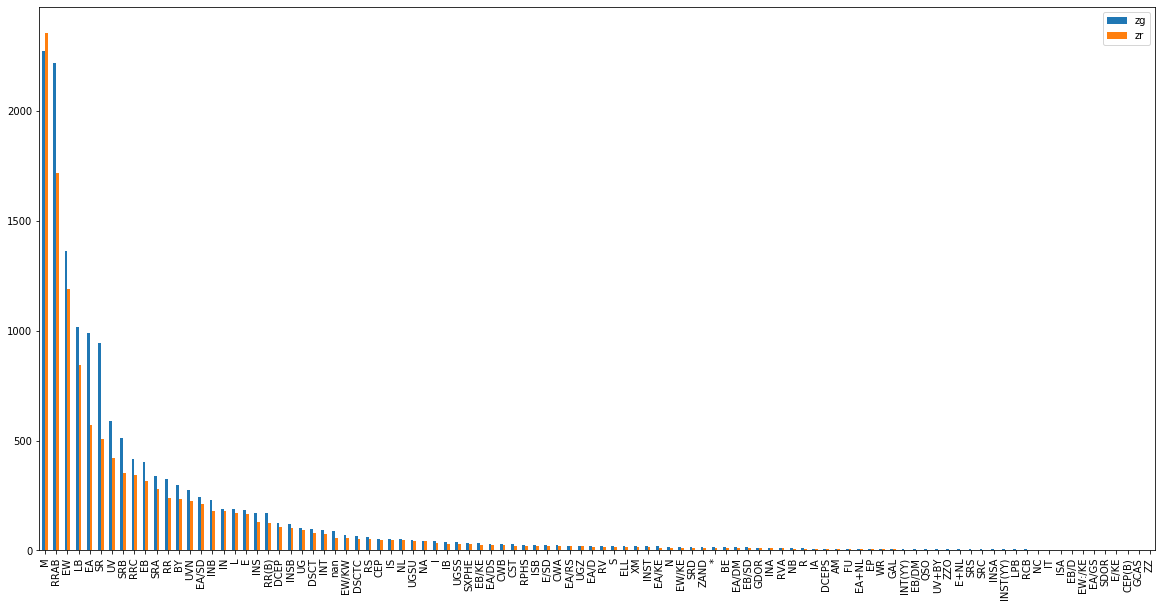

In [538]:
dfff0=pd.DataFrame(list(zip(dfff.index.tolist(),df1[df1['filter']=='zg']['Type'].value_counts().tolist(),df1[df1['filter']=='zr']['Type'].value_counts().tolist())),columns=['name','zg','zr'])
# dfff=df1['Type'].value_counts()[:100]
dfff0.index=dfff.index.tolist()
dfff0.plot(kind='bar',figsize=(20,10))

In [ ]:
names=df1['Type'].value_counts()[:90].index.tolist()

In [ ]:
k=0
list1=[]
df11=df1[df1['filter']=='zr']
for item in names:
    list1.append(df11[df11['Type']==item]['Nobs'].sum()/df11[df11['Type']==item].shape[0])
    k=k+1
t=0
list2=[]
df11=df1[df1['filter']=='zg']
for item in names:
    list2.append(df11[df11['Type']==item]['Nobs'].sum()/df11[df11['Type']==item].shape[0])
    t=t+1    

In [ ]:
obs=pd.DataFrame(list(zip(names,list1, list2)),columns=['Type','zg','zr'])
obs['Type']=names

for i in range(obs.shape[0]):
    obs['zg'][i]=int(obs['zg'][i])
    obs['zr'][i]=int(obs['zr'][i])

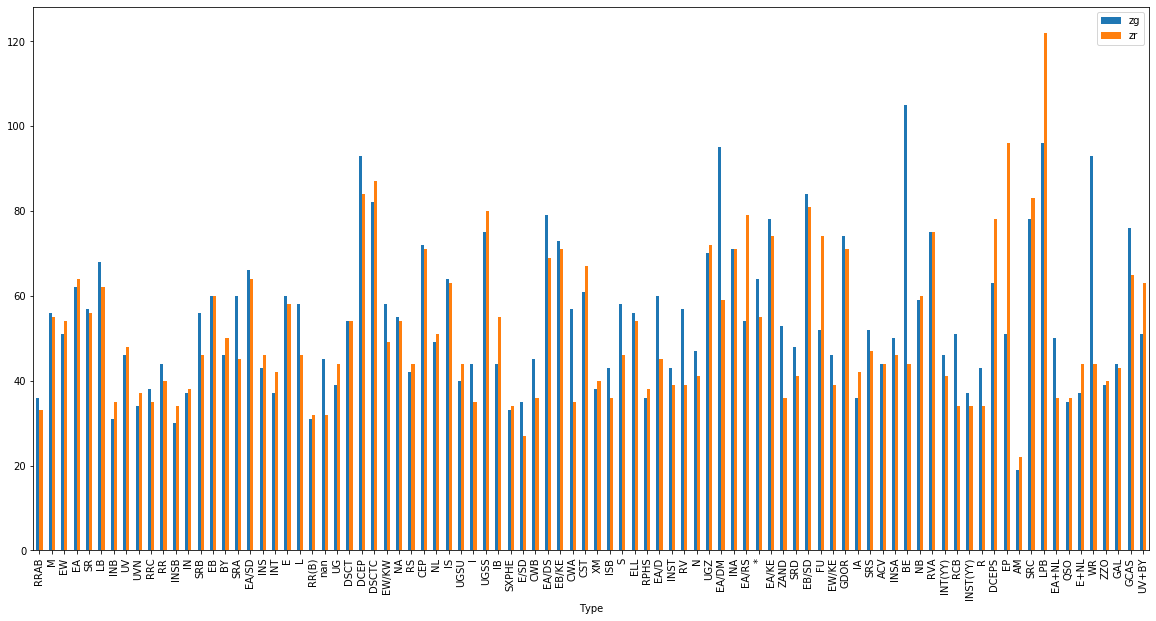

In [569]:
obs.plot(kind='bar',figsize=(20,10))

### Plot  curves for five random objects of type 'n'

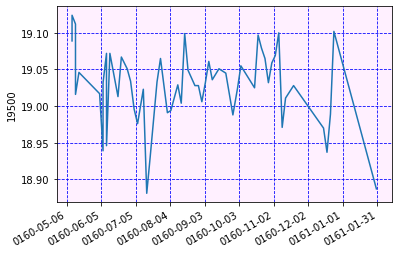

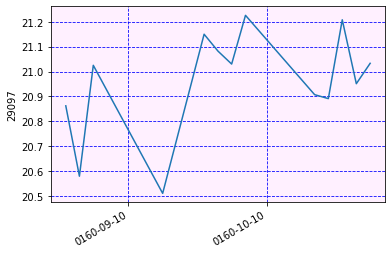

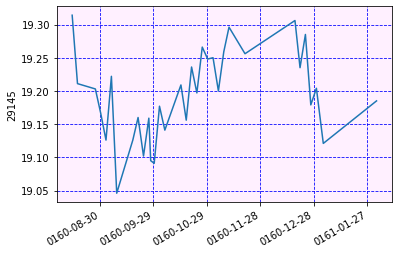

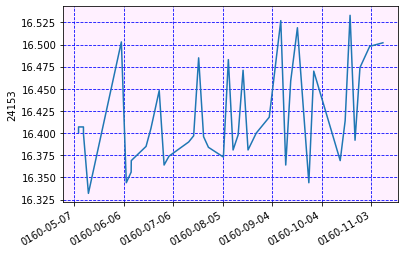

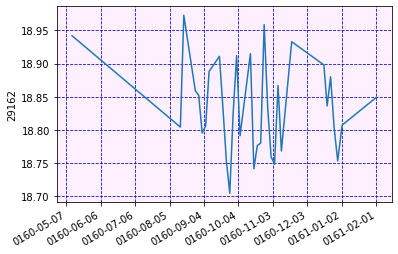

In [516]:
import random
from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates
outpath = "path/of/your/folder/"
n=2
pdf = matplotlib.backends.backend_pdf.PdfPages(str(n)+".pdf")
names=random.sample(df1[df1['Num']==n]['Name'].tolist(), 5)
for item in names:
    with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
        res = file.read().replace("'", '"')
        res=json.loads(res)
    x=[]
    y=[]
    for i in range(len(res[list(res.keys())[0]]['lc'])):
        x.append(res[list(res.keys())[0]]['lc'][i]['mjd'])
        y.append(res[list(res.keys())[0]]['lc'][i]['mag'])


#         days = mdates.drange(start,end,dt.timedelta(days=1))
    f=plt.figure()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    ax = plt.gca()
    ax.set_facecolor((1.0, 0.94, 1))
    plt.plot(x,y)
    plt.gcf().autofmt_xdate()
    plt.ylabel(item)
    plt.grid(True,color='blue',linestyle="--")
    pdf.savefig(f) #saving pdf
    plt.show()
pdf.close()

In [463]:
with open(r"C:\Users\rtut6\Desktop\Backup\1\11619.txt".format(item)) as file: 
    res = file.read().replace("'", '"')
    res=json.loads(res)

In [464]:
x=[]
y=[]
for i in range(len(res[list(res.keys())[0]]['lc'])):
    x.append(res[list(res.keys())[0]]['lc'][i]['mjd'])
    y.append(res[list(res.keys())[0]]['lc'][i]['mag'])

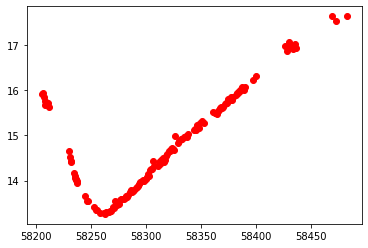

In [465]:
plt.plot(x, y, 'ro')
plt.show()

# Machine Learning 

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import roc_curve, auc,recall_score,precision_score
# from sklearn.metrics import accuracy_score

In [ ]:
# data1=df.drop(['filter','obj_id'], axis=1)

In [ ]:
# RandomForestClassifier

In [ ]:
# df1=df.iloc[1500:1725]
# array = data1.values
# X = array[:,0:7]
# Y = array[:,7]
# validation_size = 0.2
# seed = 5
# X_train=X[0:1500]
# X_validation=X[1500:1725]
# Y_train=Y[0:1500]
# Y_validation=Y[1500:1725]
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
# X_train1, X_testt, Y_train1, Y_testt = train_test_split(X_train, Y_train, test_size=validation_size1, random_state=seed)
# print(Y)
# train.head()

In [ ]:
#Learning with XGB model
# model = XGBClassifier(random_state=34, seed=7, colsample_bytree=0.8, subsample=0.6, n_estimators=2000)
# model.fit(X_train,Y_train)
# pred = model.predict(X_validation)
# accuracy = accuracy_score(Y_validation, pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# df1['pred']=pred
# df1.head(1000)

In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(np.array(obj_mjd1[9]), np.array(obj_mag1[9]))

In [ ]:
# obj_mag